In [1]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing
from iads.recommandation import prediction, traitement_reco

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from surprise import (
    SVD,
    SVDpp,
    SlopeOne,
    NMF,
    KNNBasic,
    BaselineOnly,
)
from surprise.model_selection import GridSearchCV

from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate

from lightfm.data import Dataset as LFMDataset
from lightfm.evaluation import reciprocal_rank
from lightfm import LightFM

from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

# I. Chargement des données :


In [2]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,Nombre d'avis,full_title,Note rectifiée,Note,Note Finkel,categories,Nombre d'avis rectifiés,description,titre,_id,...,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,duo,multi
0,19.0,Marvel United (2020),8.40,7.58,8.74,NaN,10.0,marvel united unir contre super vilain red sku...,Marvel United,marvel-united,...,NaN,1-4,14-99,45.0,0,1,1,1,0,1
1,33.0,Mariposas (2020),7.29,7.39,7.68,NaN,17.0,annee printemps million papillon monarque quit...,Mariposas,mariposas,...,NaN,2-5,14-99,60.0,0,1,1,0,1,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,date_published,title_review,title,note,author,treated,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",2021,Voyages sur les ailes des papillons,Mariposas,8.0,Monsieur Guillaume,True,mariposas
1,Comment continuer après un mega hit ? Simpleme...,2020,le festival de Michoacan,Mariposas,7.0,morlockbob,True,mariposas


In [4]:
users = df_avis["author"].unique()
games = df_jeux["titre"].unique()  # _id
nombre_zeros = len(df_avis) / (len(users) * len(games))
print(nombre_zeros * 100, "% des éléments sont non nuls")

0.07905386549620134 % des éléments sont non nuls


## Statistiques


In [5]:
nb_users = len(users)
nb_jeux = len(games)

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 16365 jeux


In [6]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

Text(0.5, 1.0, 'Distribution des notes des avis')

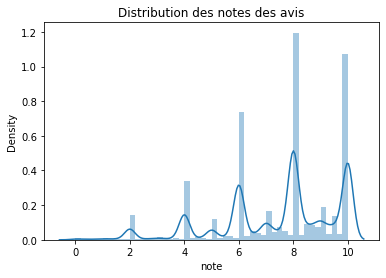

In [7]:
ax = sns.distplot(df_avis["note"])
ax.set_title("Distribution des notes des avis")

Distribution par utilisateur


Text(0.5, 0, 'Note par utilisateur')

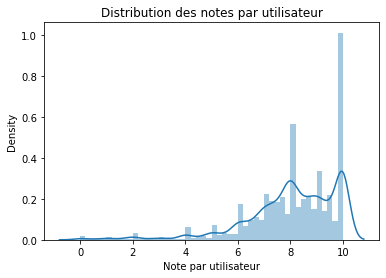

In [8]:
user_means = df_avis.groupby("author")["note"].mean()
ax = sns.distplot(user_means)
ax.set_title("Distribution des notes par utilisateur")
ax.set_xlabel("Note par utilisateur")

Distribution par jeu


Text(0.5, 0, 'Note par jeu')

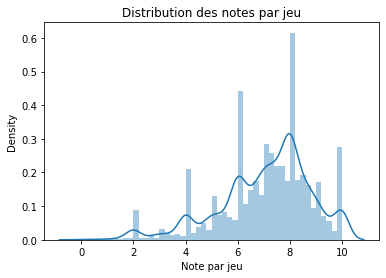

In [9]:
item_means = df_avis.groupby("title")["note"].mean()
ax = sns.distplot(item_means)
ax.set_title("Distribution des notes par jeu")
ax.set_xlabel("Note par jeu")

Vérification que chaque author n'a donné qu'un seul avis pour un jeu donné :


In [10]:
for i in df_avis.groupby(["author", "title"]):
    if len(i[1]) > 1:
        print("Duplicated author and title")
        df_avis_unique = traitement_reco.delete_dup(df_avis)
        break

Duplicated author and title


In [11]:
print("Nombre d'avis dupliqués : ", len(df_avis) - len(df_avis_unique))

Nombre d'avis dupliqués :  172


In [12]:
def describe_df(df):
    print(f"Nombre d'avis : {len(df)}")
    print(f"Nombre d'utilisateurs : {len(df['author'].unique())}")
    print(f"Nombre de jeux : {len(df['title'].unique())}")

    print("\n====================================================\n")

    _, count = np.unique(df["author"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par utilisateur")
    plt.xlabel("Utilisateurs")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

    print("\n====================================================\n")

    _, count = np.unique(df["title"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par jeu")
    plt.xlabel("Jeux")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

Nombre d'avis : 176071
Nombre d'utilisateurs : 13623
Nombre de jeux : 10709




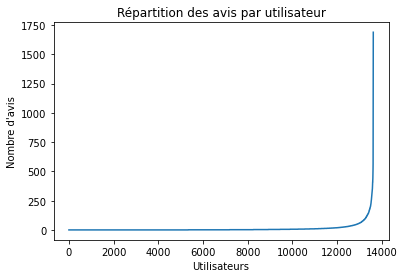

Mean = 12.924539381927623
25th percentile = 1.0
50th percentile = 2.0
75th percentile = 7.0
Minimum = 1
Maximum = 1688
Standard Deviation = 46.04849566072456




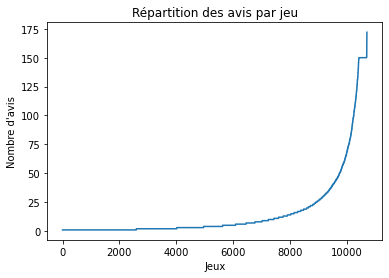

Mean = 16.441404426183585
25th percentile = 2.0
50th percentile = 4.0
75th percentile = 15.0
Minimum = 1
Maximum = 172
Standard Deviation = 31.03411212740304


In [13]:
describe_df(df_avis_unique)

## Collaborative filtering


### Demarrage à froid


On supprime les utilisateurs qui ont commenté moins de 8 fois, et les jeux avec moins de 8 avis ainsi jusqu'à convergence


In [14]:
nb_avis_min = 20

u, df_avis_filter = traitement_reco.clean_user(df_avis_unique, nb_avis_min=nb_avis_min)
g, df_avis_filter = traitement_reco.clean_game(df_avis_filter, nb_avis_min=nb_avis_min)
while u != 0 and g != 0:
    u, df_avis_filter = traitement_reco.clean_user(
        df_avis_filter, nb_avis_min=nb_avis_min)
    
    g, df_avis_filter = traitement_reco.clean_game(
        df_avis_filter, nb_avis_min=nb_avis_min)

In [15]:
game = np.unique(df_avis_unique["title"])
users = np.unique(df_avis_unique["author"])

game_filtred = np.unique(df_avis_filter["title"])
users_filtred = np.unique(df_avis_filter["author"])

print(
    "On a eliminé",
    100 * (len(users) - len(users_filtred)) / len(users),
    "% des utilisateurs",
)

print("On a eliminé", 100 * (len(game) - len(game_filtred)) / len(game), "% des jeux")

print(
    "On a eliminé",
    100 * (len(df_avis_unique) - len(df_avis_filter)) / len(df_avis_unique),
    "% des avis",
)

On a eliminé 90.7949790794979 % des utilisateurs
On a eliminé 85.67559996264823 % des jeux
On a eliminé 50.80677681162713 % des avis


Nombre d'avis : 86615
Nombre d'utilisateurs : 1254
Nombre de jeux : 1534




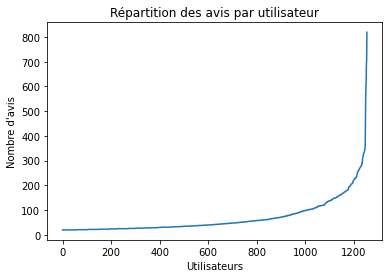

Mean = 69.07097288676236
25th percentile = 27.0
50th percentile = 42.0
75th percentile = 80.75
Minimum = 20
Maximum = 819
Standard Deviation = 73.86717401296157




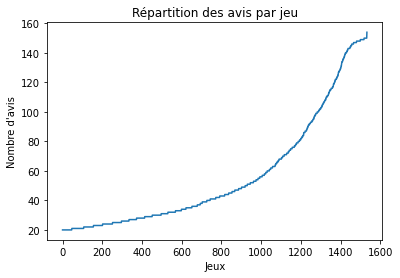

Mean = 56.46349413298566
25th percentile = 28.0
50th percentile = 41.0
75th percentile = 75.0
Minimum = 20
Maximum = 154
Standard Deviation = 37.972211204713766


In [16]:
describe_df(df_avis_filter)

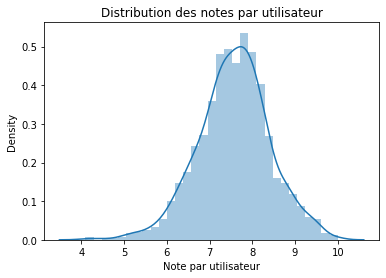

In [17]:
g_users = df_avis_filter.groupby("author")["note"].mean()
ax = sns.distplot(g_users[users_filtred])
ax.set_title("Distribution des notes par utilisateur")
ax.set_xlabel("Note par utilisateur")
plt.show()

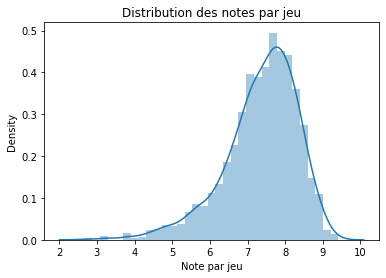

In [18]:
g_game = df_avis_filter.groupby("title")["note"].mean()
ax = sns.distplot(g_game[game_filtred])
ax.set_title("Distribution des notes par jeu")
ax.set_xlabel("Note par jeu")
plt.show()

In [19]:
train_ratings, test_ratings = train_test_split(df_avis_filter, test_size=0.2)

data = Dataset.load_from_df(train_ratings, Reader(rating_scale=(0, 10)))

In [20]:
already_play = train_ratings.groupby("author")["title"].apply(list).to_dict()

ground_truth = (
    test_ratings[test_ratings.note >= 9]
    .groupby("author")["title"]
    .apply(list)
    .to_dict()
)

existing_games = set(train_ratings["title"].unique())

In [21]:
dict_data = {
    "already_play": already_play,
    "ground_truth": ground_truth,
    "existing_games": existing_games,
    "data": data,
}

In [140]:
import itertools
import joblib
from surprise.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

def model_optim(model_class, param_grid, data, bsl_options=False):

    mse_test = []
    mae_test = []

    mse_train = []
    mae_train = []

    mse_mean = []
    mae_mean = []

    param_combinations = list(itertools.product(*[param_grid[key] for key in param_grid]))

    kf = KFold(n_splits=5, shuffle=False)

    for trainset, testset in kf.split(data):
        test_ratings = [t[2] for t in testset]
        predictions = [trainset.global_mean] * len(test_ratings)

        mse = mean_squared_error(test_ratings, predictions)
        mae = mean_absolute_error(test_ratings, predictions)

        mse_mean.append(mse)
        mae_mean.append(mae)

    mse_mean = [np.mean(mse_mean)] * len(param_combinations)
    mae_mean = [np.mean(mae_mean)] * len(param_combinations)

    def _fit(params):
        if bsl_options == False:
            model = model_class(verbose=False, **dict(zip(param_grid.keys(), params)))
        else:
            model = model_class(verbose=False, bsl_options=dict(zip(param_grid.keys(), params)))

        mse_test_p = []
        mae_test_p = []

        mse_train_p = []
        mae_train_p = []

        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset)

            mse_test_p.append(accuracy.mse(predictions, verbose=False))
            mae_test_p.append(accuracy.mae(predictions, verbose=False))

            predictions = model.test(trainset.build_testset())

            mse_train_p.append(accuracy.mse(predictions, verbose=False))
            mae_train_p.append(accuracy.mae(predictions, verbose=False))

        return (
            np.mean(mse_test_p),
            np.mean(mae_test_p),
            np.mean(mse_train_p),
            np.mean(mae_train_p),
        )

    results = joblib.Parallel(n_jobs=-1, verbose=5)(
        joblib.delayed(_fit)(params) for params in param_combinations
    )

    mse_test, mae_test, mse_train, mae_train = zip(*results)

    if len(param_combinations) > 1:
        fig, axs = plt.subplots(1, 2, figsize=(30, 10))
        plt.subplots_adjust(wspace=0.3)

        axs[0].plot(mse_test, label=f"{model_class.__name__} test")
        axs[0].plot(mse_train, label=f"{model_class.__name__} train")
        axs[0].plot(mse_mean, label="algo naif")

        axs[0].set_title("Evolution de la mse en fonction des parametres")
        axs[0].set_xticks(np.arange(len(param_combinations)))
        axs[0].set_xticklabels(param_combinations, rotation=90)
        axs[0].set_ylim(np.min([min(mse_test), min(mse_train), min(mse_mean)]) - 1, np.max([max(mse_test), max(mse_train), max(mse_mean)]) + 1)
        axs[0].legend()

        axs[1].plot(mae_test, label=f"{model_class.__name__} test")
        axs[1].plot(mae_train, label=f"{model_class.__name__} train")
        axs[1].plot(mae_mean, label="algo naif")

        axs[1].set_title('Evolution de la mae en fonction des parametres')
        axs[1].set_xticks(np.arange(len(param_combinations)))
        axs[1].set_xticklabels(param_combinations, rotation=90)
        axs[1].set_ylim(np.min([min(mae_test), min(mae_train), min(mae_mean)]) - 1, np.max([max(mae_test), max(mae_train), max(mae_mean)]) + 1)
        axs[1].legend()

        plt.show()

### Baseline algorithm


`reg_i` represent $\lambda_2$ : 

<img src="img/lambda2.png" />

`reg_u` represent $\lambda_3$ : 

<img src="img/lambda3.png" />

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed:   25.3s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   28.7s finished


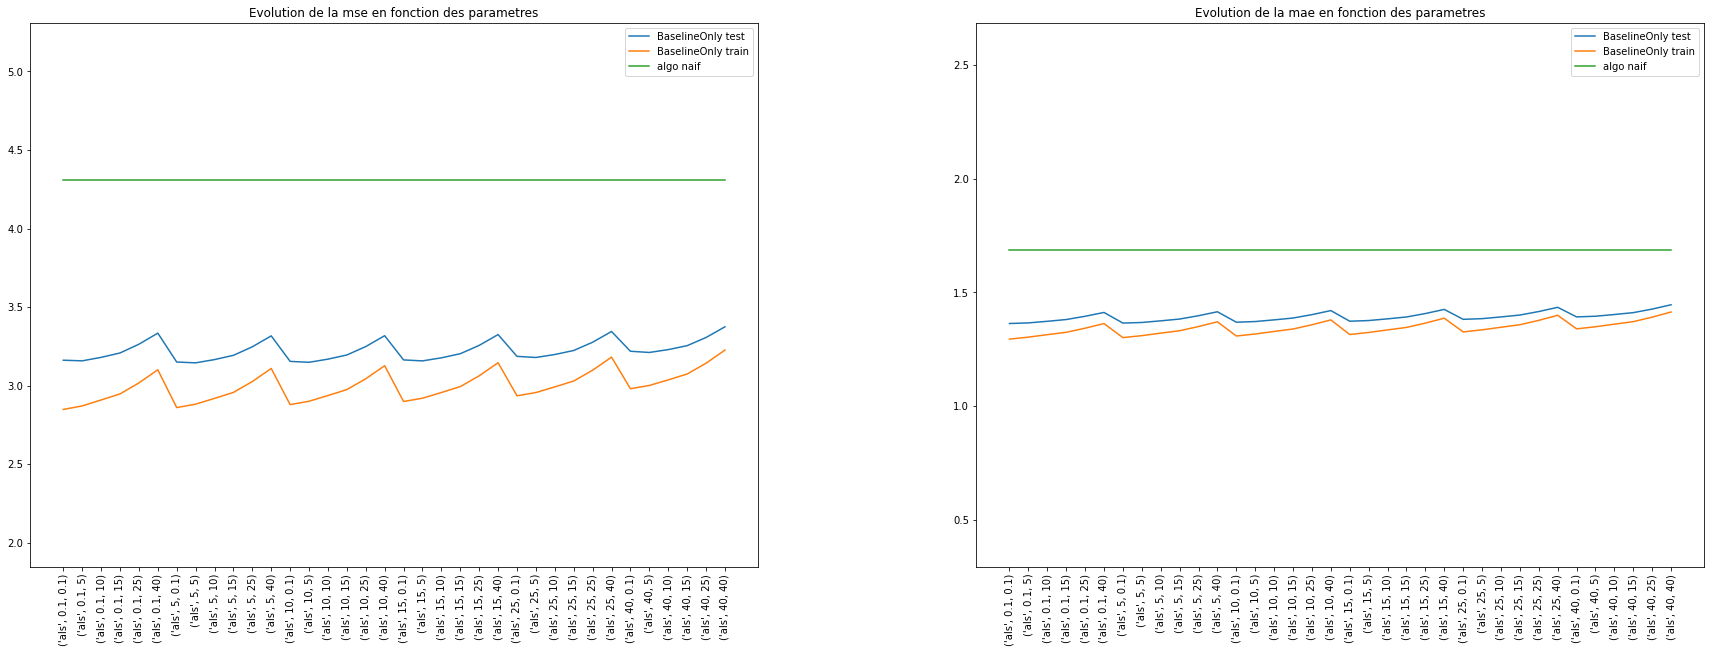

In [141]:
bsl_options = {
    "method": ["als"],
    "reg_u": [0.1, 5, 10, 15, 25, 40],
    "reg_i": [0.1, 5, 10, 15, 25, 40]
}

model_optim(BaselineOnly, bsl_options, data, bsl_options=True)

### SVD algorithm


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  40 out of  45 | elapsed:   51.8s remaining:    6.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   58.2s finished


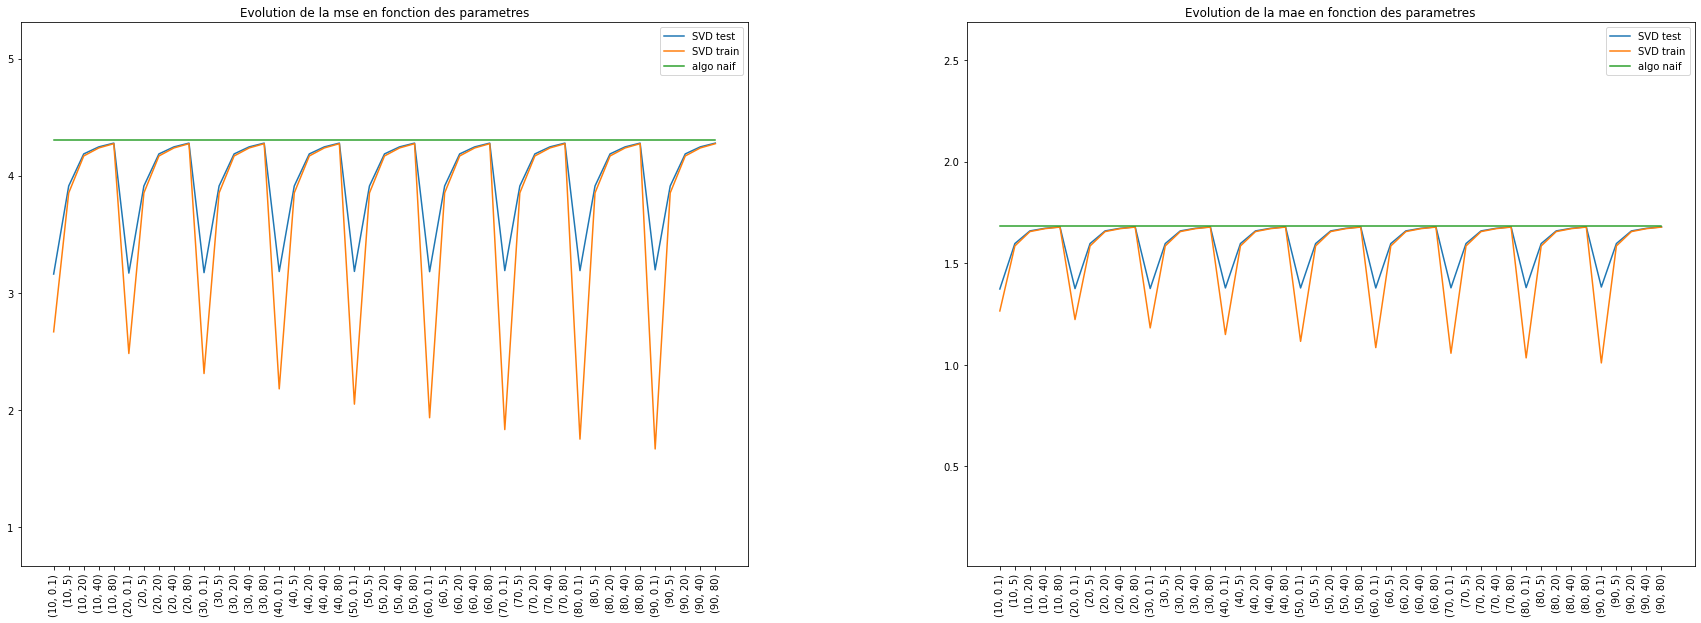

In [145]:
param_grid = {
    "n_factors": [10*i for i in range(1, 10)],
    "reg_all": [0.1, 5, 20, 40, 80],
}

model_optim(SVD, param_grid, data)

### KNN Basic


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:  1.3min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:  1.5min remaining:   30.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


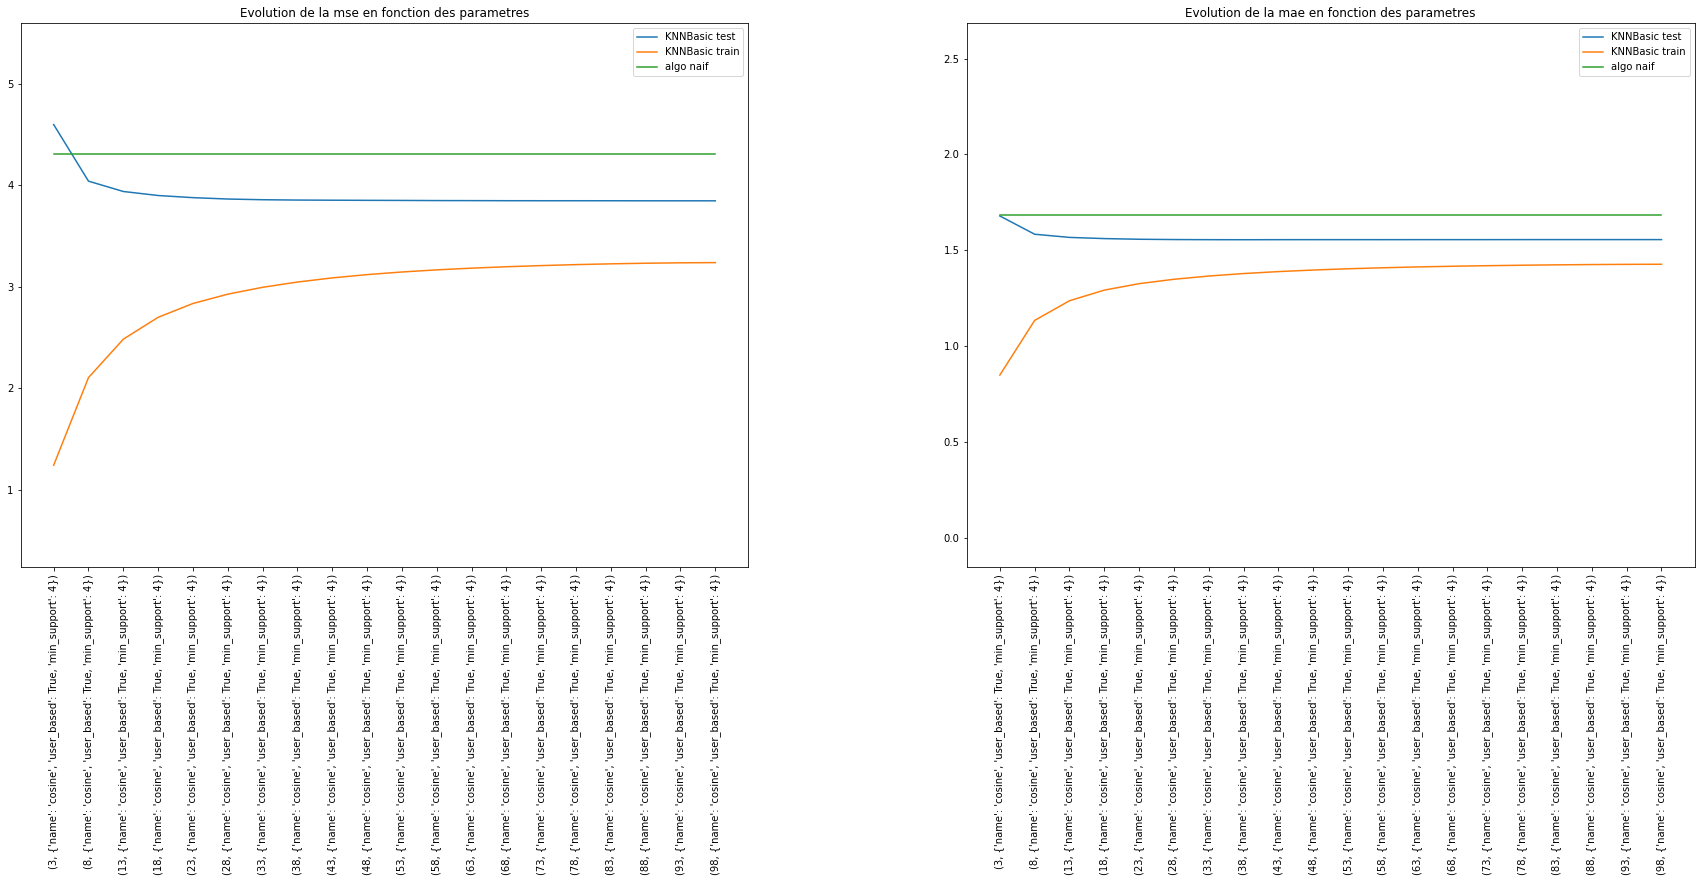

In [146]:
sim_options = {
    "name": "cosine",
    "user_based": True,
    "min_support": 4,
}

param_grid = {
    "k": list(range(3, 100, 5)),
    "sim_options": [sim_options],
}

model_optim(KNNBasic, param_grid, data)

### SVD ++

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  29 out of  36 | elapsed: 16.0min remaining:  3.9min
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 18.4min finished


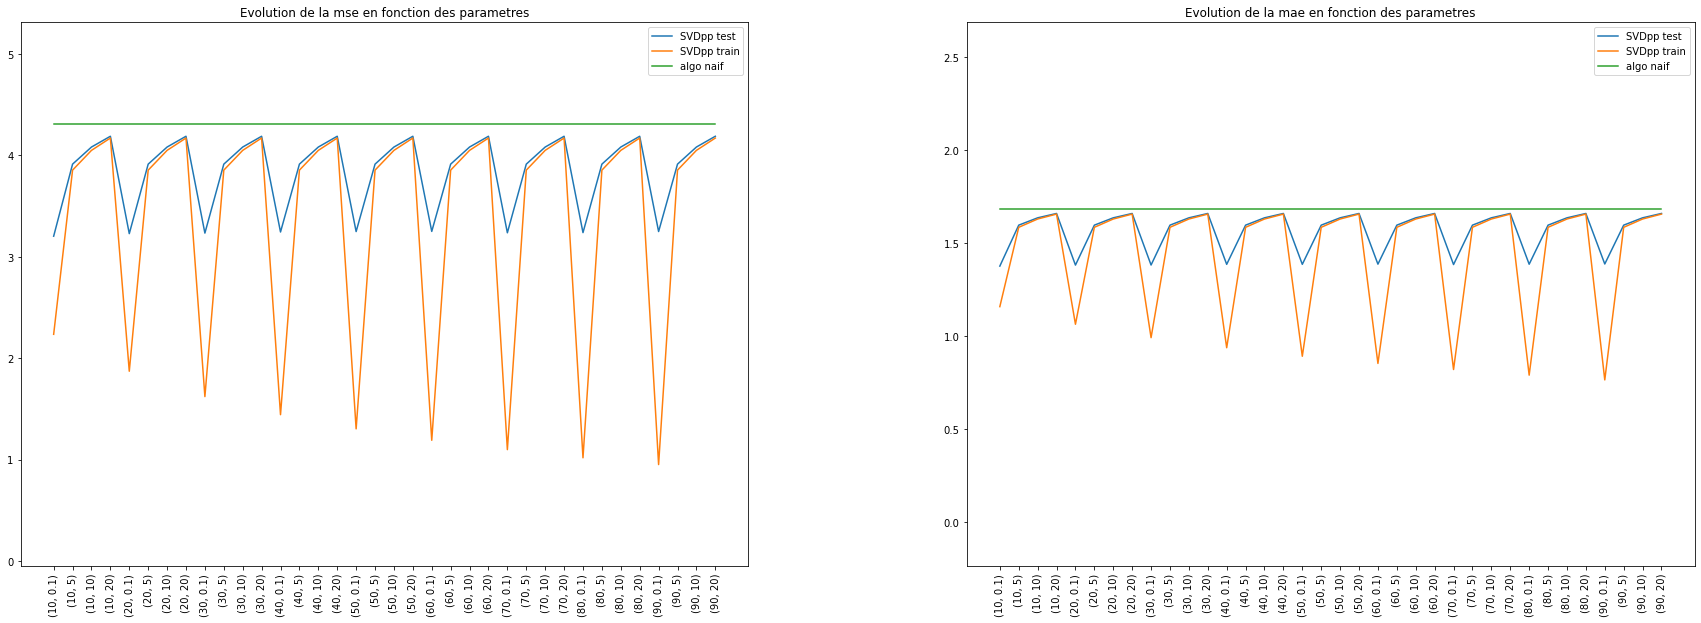

In [149]:
param_grid = {
    "n_factors": [10*i for i in range(1, 10)],
    "reg_all": [0.1, 5, 10, 20],
}

model_optim(SVDpp, param_grid, data)

In [ ]:
# models = [nmf, knn, svd, svdpp, bs]
# results_mrr = {}
# results_ndcg = {}

# for model in models:
#     predictions = predicts    ion.get_user_predictions(model, dict_data)
#     results_mrr[model.__class__.__name__] = prediction.mrr(predictions)
#     results_ndcg[model.__class__.__name__] = prediction.ndcg_at_k(predictions)

100%|██████████| 2740/2740 [00:23<00:00, 117.11it/s]


Best Model au sens de la MRR : 

In [ ]:
# model_opt_mrr = max(results_mrr, key=results_mrr.get)
# print("Le model qui maximise la mrr est :", model_opt_mrr, "avec une valeur de", results_mrr[model_opt_mrr])

Le model qui maximise la mrr est : SVD avec une valeur de 0.021151326467634794


Best Model au sens de la NDCG : 

In [ ]:
# model_opt_ndcg = max(results_ndcg, key=results_ndcg.get)
# print("Le model qui maximise la ndcg est :", model_opt_ndcg, "avec une valeur de", results_ndcg[model_opt_ndcg])

Le model qui maximise la ndcg est : NMF avec une valeur de 1.0


### Bayesian Personalized Ranking

In [ ]:
dataset = LFMDataset()
dataset.fit((x for x in df_avis["author"]),
            (x for x in df_avis['title']))

(train_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in train_ratings.itertuples())
)
    
(test_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in test_ratings.itertuples())
)

In [ ]:
bpr = LightFM(loss='bpr')
bpr.fit(train_interactions)

In [ ]:
bpr_mrr = reciprocal_rank(bpr, test_interactions, train_interactions).mean()

In [ ]:
bpr_mrr

0.03634898

## Création d'un systeme de recommandation pour un utilisateur :

In [ ]:
def basic_recommand_games(model, user, games, df, nb_games=3):
    scores = []
    
    user_games = list(df[df["author"] == user]["title"])
    
    for game in games:
        
        if game in user_games:
            scores.append(0)
            continue
        
        prediction = model.predict(user, game)
        scores.append(prediction.est)
    
    scores = np.array(scores)
    i_sort = np.argsort(-scores)
    return games[i_sort[:nb_games]]

In [ ]:
# df_avis_filter[df_avis_filter["author"] == "§Gama§"]

,author,title,note
109250,§Gama§,Ad' Astra,8.0
68944,§Gama§,Archipelago,2.0
142924,§Gama§,Attacktix,4.0
153727,§Gama§,Crimson Skies CMG,8.0
99583,§Gama§,César et Cléopâtre,10.0
173667,§Gama§,Draco & Co,8.0
115912,§Gama§,Elfenland,8.0
170665,§Gama§,Hanafuda,2.0
114452,§Gama§,Illuminati,8.0
155690,§Gama§,L'Escalier Hanté,4.0


In [ ]:
# nmf_games = basic_recommand_games(nmf, '§Gama§', games, df_avis, nb_games=20)
# nmf_games

array(['Hammer of the Scots', 'Snowdonia',
       'Orléans : Commerce et Intrigue',
       'Pandémie : Au Seuil de la Catastrophe',
       'Mice and Mystics : Chroniques des sous Bois',
       'Pandemic Legacy - Saison 2', 'Here I Stand',
       'Olympos : Oikoumene', 'Le Trône de Fer - JCE',
       'The Resistance : Avalon', 'Dany',
       'Le Seigneur des Anneaux : Champs de Batailles',
       'Le Trône de Fer - JdS : Tempête de Lames', 'Firenze',
       'Keltis - Das Kartenspiel', 'Summoner Wars : les avangardes',
       "Through The Ages : L'Histoire vous appartient",
       "Aeon's End: Guerre éternelle",
       'Robinson Crusoé - Aventures sur l\'Île Maudite - Extension "Le Voyage du Beagle"',
       'Fléchettes'], dtype=object)

In [ ]:
# svdpp_games = basic_recommand_games(svdpp, '§Gama§', games, df_avis, nb_games=20)
# svdpp_games

array(['Antiquity', 'Warhammer, le jeu de rôle fantastique',
       'Roads & Boats', 'Steam - Les Voies de la Richesse',
       'Rallyman : Dirt', 'Dominion - Age des ténèbres',
       'Pandemic Legacy - Saison 2',
       'Mémoire 44 : Carnets de Campagne Vol.1',
       'Twilight Imperium : Shattered Empire', 'Space Alert',
       'Mare Nostrum : extension mythologique',
       'Summoner Wars : le royaume déchu',
       "Conflict of Heroes : Le Réveil de l'Ours",
       "Horreur à Arkham : L'Horreur de Dunwich",
       "Conflict of Heroes : Le réveil de l'Ours Solo", 'Abyss Leviathan',
       'Goa', 'Imperial', 'Netrunner', 'Crokinole'], dtype=object)